# To Dos

[x] Add export nodes
[x] Add 2050 loads and generation
[x] Test storage
[x] Test new lines 


We applied the pandapower module to compare Thailand's current 2024 electricity grid and projected 2050 constraints.

Analysis is at a high level- we relied on the division of Thailand into four regions based on the four subdivisions that the Thai EGAT authority uses:
- North
- Northeast
- Central/Bangkok
- South

On top on these four nodes, we added the import and export nodes Thailand is connected to. Namely:
- Imports:
  - Hong Sa coal plant in Laos
  - Nam Ngum dam in Laos
  - Laos-Theun-Hinboun dam in Laos
  - Houay Ho dam in Laos
- Exports:
  - Cambodia
  - Malaysia-Singapore

  ##### **All input data is editable on `ThaiModelInput.xlsx`**


In [1]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
import pandapower as pp
import pandapower.plotting as plot



In [2]:
MODEL_2050 = True

In [3]:
# Create network
net = pp.create_empty_network() 

In [4]:
#Read bus data from excel
bus_df= pd.read_excel('ThaiModelInput.xlsx', sheet_name='buses',nrows=10)
#bus_df

In [5]:
# Create buses
b = {}

for i in bus_df['bus_id']:
  b[i] = pp.create_bus(net, vn_kv = bus_df.loc[bus_df['bus_id']==i, 'vn_kv'].values[0], name = bus_df.loc[bus_df['bus_id']==i, 'name'].values[0], geodata = eval(bus_df.loc[bus_df['bus_id']==i, 'geodata'].values[0]),min_vm_pu=0.85)
net.bus

,name,vn_kv,type,zone,in_service,min_vm_pu
0,Thailand-North,500.0,b,None,True,0.85
1,Thailand-Northeast,230.0,b,None,True,0.85
2,Thailand-Bangkok,500.0,b,None,True,0.85
3,Thailand-South,230.0,b,None,True,0.85
4,Import-Laos-Hong Sa,500.0,b,None,True,0.85
5,Import-Laos-Nam Ngum,115.0,b,None,True,0.85
6,Import-Laos-Theun-Hinboun,230.0,b,None,True,0.85
7,Import-Laos-Houay Ho,230.0,b,None,True,0.85
8,Export-Cambodia,115.0,b,None,True,0.85
9,Export-Malaysia,300.0,b,None,True,0.85


In [6]:
# Create one grid connection point
connect_bus = b[0] 
vm_pu = 1.1

# Create the external grid connection
pp.create_ext_grid(net, bus=connect_bus, vm_pu=vm_pu, name = "Slack bus")

0

In [7]:
# Import line data from excel file-- from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, max_i_ka
line_df = pd.read_excel('ThaiModelInput.xlsx', sheet_name='lines',nrows=22)
#line_df

In [8]:
# Create lines
for i in line_df.index:
  print(i)
  pp.create_line_from_parameters(net, from_bus=b[line_df.loc[i, 'from_bus']],
                                 to_bus=b[line_df.loc[i, 'to_bus']],
                                 length_km=line_df.loc[i, 'length_km'],
                                 r_ohm_per_km=line_df.loc[i, 'r_ohm_per_km'],
                                 x_ohm_per_km=line_df.loc[i, 'x_ohm_per_km'],
                                 c_nf_per_km=line_df.loc[i, 'c_nf_per_km'],
                                 max_i_ka=line_df.loc[i, 'max_i_ka']
                                 ) 
net.line

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,None,None,0,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
1,None,None,0,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
2,None,None,0,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
3,None,None,0,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
4,None,None,0,1,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
5,None,None,0,1,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
6,None,None,1,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
7,None,None,1,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
8,None,None,1,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
9,None,None,1,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True


In [9]:
# Import Load data from excel-- geolocation, bus (nearest from geolocation), p_mw

load_df = pd.read_excel('ThaiModelInput.xlsx', sheet_name='loads',nrows=10)
#load_df

In [10]:
# Create loads

for i in load_df['bus_id']:
  pp.create_load(net, 
                 b[i], 
                 p_mw=load_df.loc[load_df['bus_id']==i, 'power_p_mw_2050'  if MODEL_2050 else 'power_p_mw'].values[0], 
                 q_mvar=load_df.loc[load_df['bus_id']==i, 'power_q_mvar_2050'  if MODEL_2050 else 'power_q_mvar'].values[0],
                 name=load_df.loc[load_df['bus_id']==i, 'name'].values[0]
                 )

In [11]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,Thailand-North,0,13291.961143,6440.904618,0.0,0.0,NaN,1.0,True,wye
1,Thailand-Northeast,1,18158.371714,8799.028148,0.0,0.0,NaN,1.0,True,wye
2,Thailand-Bangkok,2,120454.185857,58368.657090,0.0,0.0,NaN,1.0,True,wye
3,Thailand-South,3,13410.037653,6498.121122,0.0,0.0,NaN,1.0,True,wye
4,Import-Laos-Hong Sa,4,-1473.000000,-713.773716,0.0,0.0,NaN,1.0,True,wye
5,Import-Laos-Nam Ngum,5,-150.000000,-72.685715,0.0,0.0,NaN,1.0,True,wye
6,Import-Laos-Theun-Hinboun,6,-1000.000000,-484.571430,0.0,0.0,NaN,1.0,True,wye
7,Import-Laos-Houay Ho,7,-150.000000,-72.685715,0.0,0.0,NaN,1.0,True,wye
8,Export-Cambodia,8,135.500000,65.659429,0.0,0.0,NaN,1.0,True,wye
9,Export-Malaysia,9,100.000000,48.457143,0.0,0.0,NaN,1.0,True,wye


In [12]:
# Generators imported from excel
vm_pu=1.1

gen_df = pd.read_excel('ThaiModelInput.xlsx', sheet_name='gen',nrows=4)
#gen_df    

In [13]:
#Generators
for i in gen_df['gen_id']:
  pp.create_sgen(net,
                 bus = gen_df.loc[gen_df['gen_id']==i, 'bus_id'].values[0],
                 p_mw = gen_df.loc[gen_df['gen_id']==i, 'p_mw_2050' if MODEL_2050 else 'p_mw'].values[0],
                 vm_pu = 1, 
                 name = gen_df.loc[gen_df['gen_id']==i, 'name'].values[0]
                 )
net.gen


,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type


In [14]:
#Storage entries are added manually

# pp.create_storage(net,0, p_mw=10000, max_e_mwh=50000) # Thailand-North
# pp.create_storage(net,1, p_mw=10000, max_e_mwh=50000) # Thailand-Northeast
# pp.create_storage(net,2, p_mw=10000, max_e_mwh=50000) # Thailand-Bangkok
# pp.create_storage(net,3, p_mw=10000, max_e_mwh=50000) # Thailand-South

3

<Axes: >

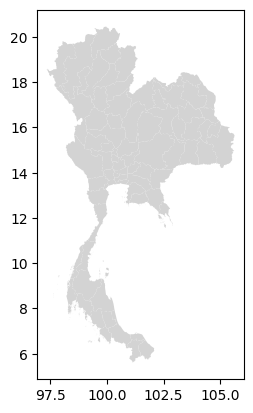

In [15]:
thailand = gpd.read_file('thai.shp')
thailand.plot(ax=plt.gca(), color='lightgrey')


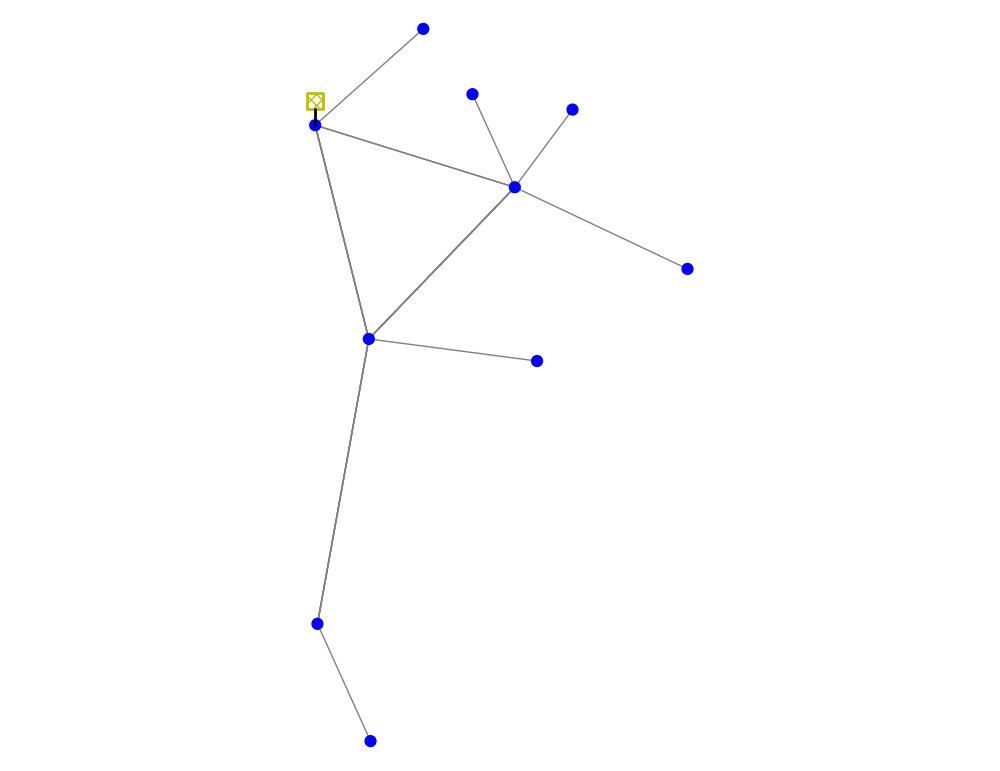

<Axes: >

In [16]:
pp.plotting.simple_plot(net)

In [17]:
pp.diagnostic(net)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



_____________ PANDAPOWER DIAGNOSTIC TOOL _____________ 


 --------


 --------

Checking for connections of different voltage levels...

line 4 connects bus 0: Thailand-North (vn_kv = 500.0) and bus 1: Thailand-Northeast (vn_kv = 230.0)
line 5 connects bus 0: Thailand-North (vn_kv = 500.0) and bus 1: Thailand-Northeast (vn_kv 

{'different_voltage_levels_connected': {'lines': [4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   15,
   18,
   19]},
 'wrong_reference_system': {'loads': [4, 5, 6, 7]}}

In [18]:
# Run the network using the NR algorithm
pp.runpp(net,algorithm='nr', max_iteration=10000);



numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [19]:
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,None,None,0,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
1,None,None,0,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
2,None,None,0,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
3,None,None,0,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
4,None,None,0,1,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
5,None,None,0,1,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
6,None,None,1,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
7,None,None,1,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
8,None,None,1,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True
9,None,None,1,2,400.0,0.01,0.01,1.000000e-09,0.0,40.0,1.0,1,None,True


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


<Axes: >

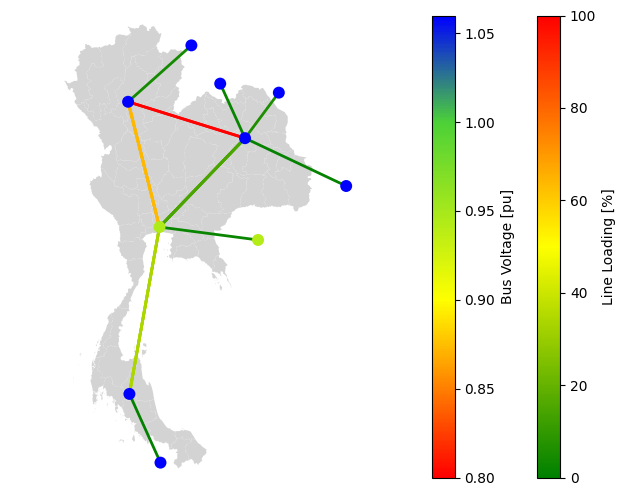

In [20]:
cmap_list=[(0, "green"), (50, "yellow"), (100, "red")]
cmap, norm = plot.cmap_continuous(cmap_list)

lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=cmap, norm=norm, linewidths=2)
#plot.draw_collections([lc], figsize=(8,6))


ideal_color = "#4cd137"
too_high_color = "blue"
too_low_color = "yellow"
very_low_color = "red"
cmap_list=[(0.8, very_low_color), (0.9, too_low_color), (1.0, ideal_color), (1.06, too_high_color)] #+6 and -10 percent for voltage regulations
cmap, norm = plot.cmap_continuous(cmap_list)
bc = plot.create_bus_collection(net, net.bus.index, size=0.2, zorder=2, cmap=cmap, norm=norm)

# Plot the map of Thailand as the background
fig, ax = plt.subplots(figsize=(8, 6))
thailand.plot(ax=ax, color='lightgrey')


plot.draw_collections([lc,bc], figsize=(8,6),ax=ax)

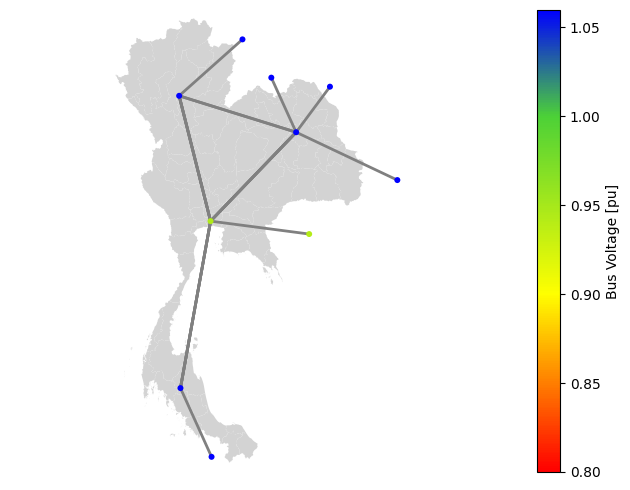

In [21]:
# Define the color map for voltage regulation
ideal_color = "#4cd137"
too_high_color = "blue"
too_low_color = "red"
cmap_list = [(0.8, "red"), (0.9, "yellow"), (1.0, ideal_color), (1.06, too_high_color)]  # +6 and -10 percent for voltage regulations
cmap, norm = plot.cmap_continuous(cmap_list)

# Plot the map of Thailand as the background
fig, ax = plt.subplots(figsize=(8, 6))
thailand.plot(ax=ax, color='lightgrey')

# Create bus and line collections
lc = plot.create_line_collection(net, net.line.index, color="grey", linewidths=2, use_bus_geodata=True, zorder=1)
bc = plot.create_bus_collection(net, net.bus.index, size=0.1, zorder=2, cmap=cmap, norm=norm)

# Draw the collections
plot.draw_collections([lc, bc], ax=ax)

plt.show()


In [22]:
# Print the elements of the network
net

This pandapower network includes the following parameter tables:
   - bus (10 element)
   - load (10 element)
   - sgen (4 element)
   - storage (4 element)
   - ext_grid (1 elements)
   - line (20 element)
   - bus_geodata (10 element)
 and the following results tables:
   - res_bus (10 element)
   - res_line (20 element)
   - res_ext_grid (1 elements)
   - res_load (10 element)
   - res_sgen (4 element)
   - res_storage (4 element)

In [23]:
# Display line results
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,-5860.615753,23550.142722,13648.464205,-15762.294269,7787.848453,7787.848453,25.475231,25.475231,25.475231,1.100000,0.000000,0.945064,26.914482,63.688076
1,-5860.615753,23550.142722,13648.464205,-15762.294269,7787.848453,7787.848453,25.475231,25.475231,25.475231,1.100000,0.000000,0.945064,26.914482,63.688076
2,-5860.615753,23550.142722,13648.464205,-15762.294269,7787.848453,7787.848453,25.475231,25.475231,25.475231,1.100000,0.000000,0.945064,26.914482,63.688076
3,-5860.615753,23550.142722,13648.464205,-15762.294269,7787.848453,7787.848453,25.475231,25.475231,25.475231,1.100000,0.000000,0.945064,26.914482,63.688076
4,-13652.846636,14375.112193,18850.123619,-9177.835210,5197.276983,5197.276983,20.811209,45.241758,45.241758,1.100000,0.000000,1.163271,20.515417,113.104396
5,-13652.846636,14375.112193,18850.123619,-9177.835210,5197.276983,5197.276983,20.811209,45.241758,45.241758,1.100000,0.000000,1.163271,20.515417,113.104396
6,913.558056,2533.982263,-508.125329,-2128.549536,405.432728,405.432728,5.812578,2.673786,5.812578,1.163271,20.515417,0.945064,26.914482,14.531444
7,913.558056,2533.982263,-508.125329,-2128.549536,405.432728,405.432728,5.812578,2.673786,5.812578,1.163271,20.515417,0.945064,26.914482,14.531444
8,913.558056,2533.982263,-508.125329,-2128.549536,405.432728,405.432728,5.812578,2.673786,5.812578,1.163271,20.515417,0.945064,26.914482,14.531444
9,913.558056,2533.982263,-508.125329,-2128.549536,405.432728,405.432728,5.812578,2.673786,5.812578,1.163271,20.515417,0.945064,26.914482,14.531444


In [24]:
# Display bus results
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.100000,0.000000,52195.677910,-122262.499931
1,1.163271,20.515417,-40105.135542,8799.028148
2,0.945064,26.914482,-37132.161987,58368.657090
3,1.071851,50.592936,-22247.173956,6498.121122
4,1.123330,0.422453,-1473.000000,-713.773716
5,1.191494,20.998752,-150.000000,-72.685714
6,1.231400,21.684665,-1000.000000,-484.571430
7,1.177560,20.759942,-150.000000,-72.685714
8,0.941645,26.842537,135.500000,65.659429
9,1.068962,50.539340,100.000000,48.457143


In [25]:
# Display generator results
net.res_gen

,p_mw,q_mvar,va_degree,vm_pu


In [26]:
#Display transformer results
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


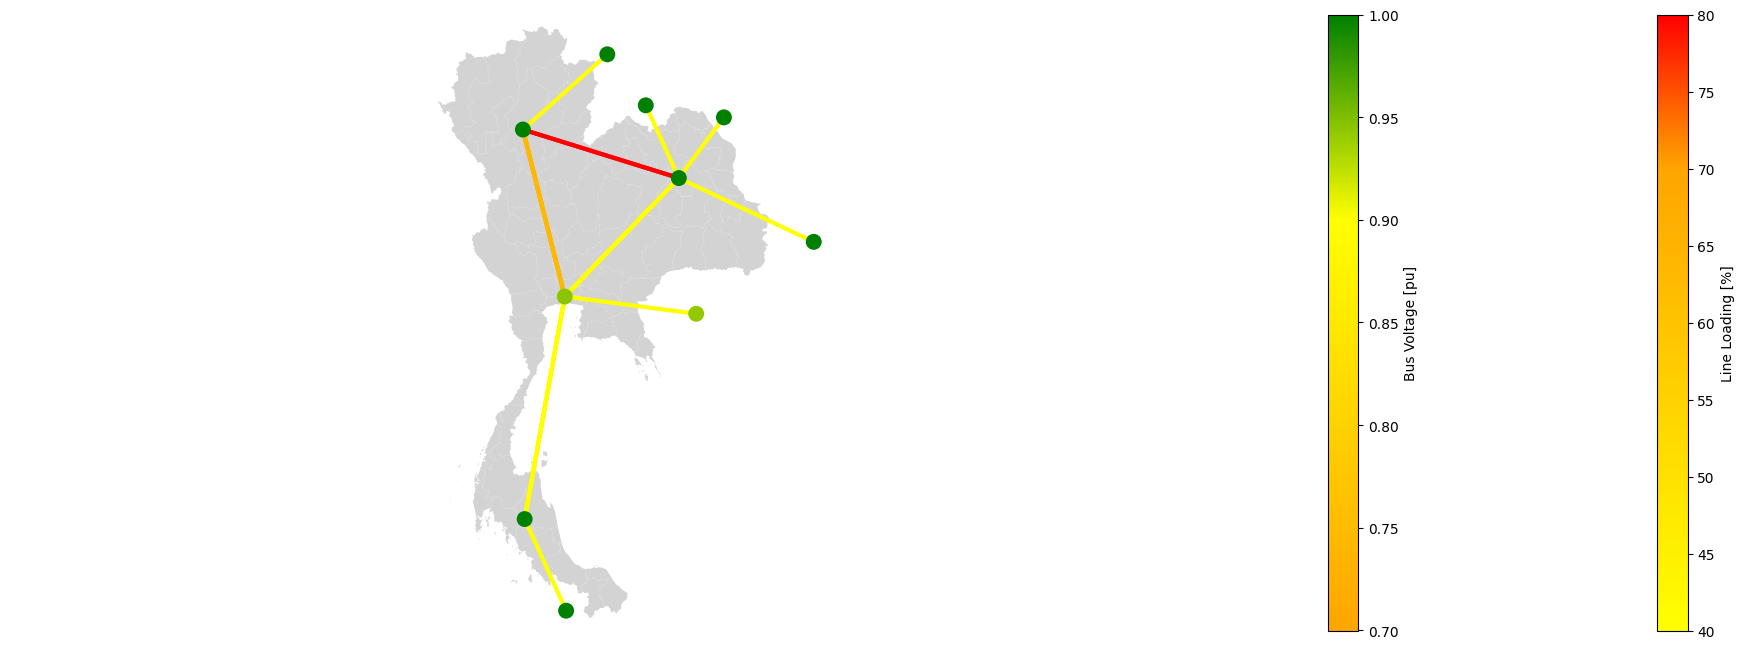

In [27]:
# Define the line color map
line_cmap_list = [(40, "yellow"), (70, "orange"), (80, "red")]
line_cmap, line_norm = plot.cmap_continuous(line_cmap_list)

# Create the line color collection
lc = plot.create_line_collection(net, net.line.index, zorder=1, cmap=line_cmap, norm=line_norm, linewidths=3)

# Define the bus color map
bus_cmap_list = [(0.7, "orange"), (0.9, "yellow"), (1.0, "green")]
bus_cmap, bus_norm = plot.cmap_continuous(bus_cmap_list)

# Create the bus color collection
bc = plot.create_bus_collection(net, net.bus.index, size=0.2, zorder=2, cmap=bus_cmap, norm=bus_norm)

# Plot the map of Thailand as the background
fig, ax = plt.subplots(figsize=(25, 8))
thailand.plot(ax=ax, color='lightgrey')

# Draw the collections
plot.draw_collections([lc, bc], ax=ax)

plt.show()

In [28]:
#Print results to an excel file
#pp.to_excel(net, "results.xlsx") 

In [29]:
# # Create the transformers

# # First Transformer
# #North (115) to Thailand_north (230)
# lv_bus = net.bus[net.bus.name == 'North'].index.values[0]
# hv_bus = net.bus[net.bus.name == 'trafo_b0'].index.values[0]

# # Parameters assumed equal to those of the 100 MVA 220/110 kV standard type
# sn_mva = 400
# vn_hv_kv = 230
# vn_lv_kv = 115
# vk_percent = 12
# vkr_percent = 0.26
# pfe_kw = 3.2
# i0_percent = 0.06
# pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)

# # Second Transformer
# #Central 1 (115) to Thailand_c1 (230)
# lv_bus = net.bus[net.bus.name == 'Central 1'].index.values[0]
# hv_bus = net.bus[net.bus.name == 'trafo_b1'].index.values[0]


# sn_mva = 4000
# vn_hv_kv = 230
# vn_lv_kv = 115
# vk_percent = 12
# vkr_percent = 0.26
# pfe_kw = 3.2
# i0_percent = 0.06
# pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)

# # Third Transformer
# #South (115) to Vietnam (230)
# lv_bus = net.bus[net.bus.name == 'South'].index.values[0]
# hv_bus = net.bus[net.bus.name == 'trafo_b3'].index.values[0]

# sn_mva = 40000
# vn_hv_kv = 230
# vn_lv_kv = 115
# vk_percent = 12
# vkr_percent = 0.26
# pfe_kw = 3.2
# i0_percent = 0.06
# pp.create_transformer_from_parameters(net, hv_bus=hv_bus, lv_bus=lv_bus, sn_mva=sn_mva, vn_hv_kv=vn_hv_kv, vn_lv_kv=vn_lv_kv, vkr_percent=vkr_percent, vk_percent=vk_percent, pfe_kw=pfe_kw, i0_percent=i0_percent)